In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
import tensorflow
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

#### Reading the data
Read the csv into a pandas dataframe and then display the first few rows of data to understand the values.

In [2]:
imdb_df = pd.read_csv('IMDB Dataset.csv')
imdb_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


#### Visualizing and preprocessing the data
Understanding the distribution of values in the data by visualizing it and performing some necessary preprocessing steps on it

In [3]:
imdb_df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


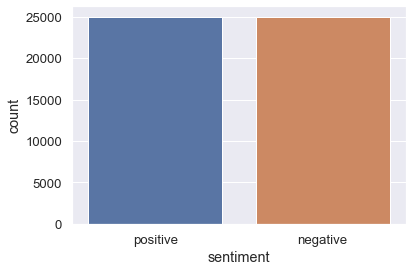

In [4]:
sns.set(style = "darkgrid" , font_scale = 1.2)
sns.countplot(x='sentiment',data=imdb_df)
plt.show()

From the above plot, we can see that the dataset is balanced.

In [5]:
imdb_df.isna().sum()   #checking for missing values

review       0
sentiment    0
dtype: int64

### Basic Data Cleaning 

<ol>
<li>The review section consists of text alongwith some html code. To remove the html code, we will use the python webscraping library Beautiful Soup</li>

<li>To remove the urls and punctuations, we will use regular expressions in python</li>
    
</ol>

In [6]:
def strip_html(text):
    soup = BeautifulSoup(text,"html.parser")
    return soup.get_text()

#function to remove punctuations
def remove_punctuations(text):
    punctuations = re.compile(r'[^\w\s]')
    text = punctuations.sub(r'',text)
    return text
    

#### Removing stopwords
Stopwords are those words that do not provide any useful information to decide in which category a text should be classified. This may be either because they don't have any meaning (prepositions, conjunctions, etc.) or because they are too frequent in the classification context.
We remove these words as they do not provide much weight to the overall sentiment of the sentence

In [7]:
stopwrds = stopwords.words('english')

def remove_stopwords(text):
    final_text =[]
    for i in text.split():
        #print(i.strip().lower())
        if i.strip().lower() not in stopwrds and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
            
    return " ".join(final_text)

            

In [8]:
# applying the functions to the review column

imdb_df['review'] = imdb_df['review'].apply(strip_html)
imdb_df['review'] = imdb_df['review'].apply(remove_punctuations)
imdb_df['review'] = imdb_df['review'].apply(remove_stopwords)

#### Label encoding
We will perform label encoding on our dataset on the column sentiment, to replace the categorical variable with an integer variable so that it is more machine readable. 

In [9]:
le = LabelEncoder()
imdb_df['sentiment'] = le.fit_transform(imdb_df['sentiment'])
imdb_df.head()

,review,sentiment
0,one reviewers mentioned watching oz episode yo...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically theres family little boy jake thinks...,0
4,petter matteis love time money visually stunni...,1


#### Wordcloud for positive text - label 1

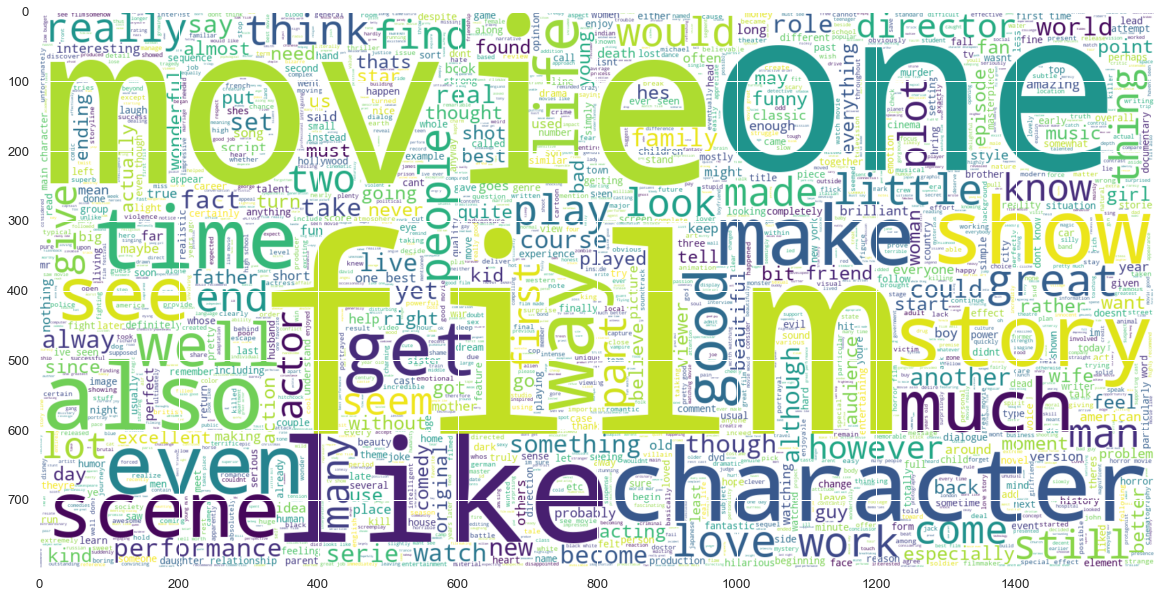

In [10]:
plt.figure(figsize = (20,20))
wrdcld = WordCloud(max_words=2000,width=1600, height =800,
                   stopwords = stopwrds,background_color='white').generate("".join(imdb_df[imdb_df['sentiment']==1].review))
plt.imshow(wrdcld,interpolation = 'bilinear')

#### Wordcloud for negative text - label 0

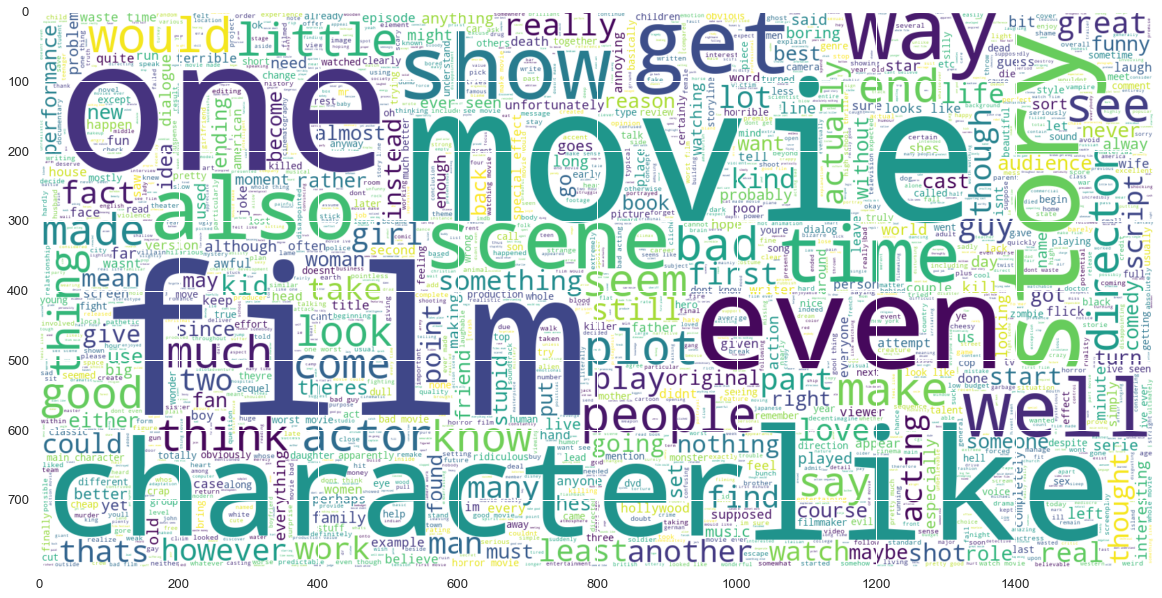

In [11]:
plt.figure(figsize = (20,20))
wrdcld = WordCloud(max_words=2000,width=1600, height =800,
                   stopwords = stopwrds,background_color='white').generate("".join(imdb_df[imdb_df['sentiment']==0].review))
plt.imshow(wrdcld,interpolation = 'bilinear')

#### Splitting data into Train and Test Sets

In [12]:
X = imdb_df['review']
y = imdb_df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

### Count Vectorizer
The count of a word in a particular sample or review becomes the value of the corresponding word vector

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

count_vec = CountVectorizer()
countvec_train = count_vec.fit_transform(X_train)
countvec_test = count_vec.transform(X_test)

countvec_train.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

<b> So we can see the data has become numeric with 1,2 and 3s based on the number of times they appear in the text.
</b>

### TF-IDF Vectorizer
TF stands for Text Frequency which means how many times a word (term) appears in a text (document). IDF means Inverse Document Frequency and is calculated as log(# of documents in corpus/# of documents containing the term).
<br> <br>
Finally TF-IDF score is calculated as TF * IDF. <br> <br>
IDF acts as a balancing factor and diminishes the weight of terms that occur very frequently in the document set and increases the weight of terms that occur rarely.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer()
tfidfvec_train = tfidf_vec.fit_transform(X_train)
tfidfvec_test = tfidf_vec.transform(X_test)

tfidfvec_train.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Now, applying the techniques to test the performance of the model

### LinearSVC 
Linear Support Vector Classification with tfidf

In [16]:
from sklearn.svm import LinearSVC

linear_svc = LinearSVC(C=0.5, random_state=42)
linear_svc.fit(tfidfvec_train, y_train)

predict = linear_svc.predict(tfidfvec_test)

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Classification Report: \n", classification_report(y_test, predict,target_names=['Negative','Positive']))
print("Confusion Matrix: \n", confusion_matrix(y_test, predict))
print("Accuracy: \n", accuracy_score(y_test, predict))

Classification Report: 
               precision    recall  f1-score   support

    Negative       0.91      0.89      0.90      7539
    Positive       0.89      0.91      0.90      7461

    accuracy                           0.90     15000
   macro avg       0.90      0.90      0.90     15000
weighted avg       0.90      0.90      0.90     15000

Confusion Matrix: 
 [[6673  866]
 [ 697 6764]]
Accuracy: 
 0.8958


Linear Support Vector classifier with count vectorizer

<br> <br>
<b>binary=False in count vectorizer

In [18]:
linear_svc_count = LinearSVC(C=0.5, random_state=42, max_iter=5000)
linear_svc_count.fit(countvec_train, y_train)

predict_count = linear_svc_count.predict(countvec_test)


In [19]:
print("Classification Report: \n", classification_report(y_test, predict_count,target_names=['Negative','Positive']))
print("Confusion Matrix: \n", confusion_matrix(y_test, predict_count))
print("Accuracy: \n", accuracy_score(y_test, predict_count))

Classification Report: 
               precision    recall  f1-score   support

    Negative       0.87      0.86      0.87      7539
    Positive       0.86      0.87      0.87      7461

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000

Confusion Matrix: 
 [[6507 1032]
 [ 936 6525]]
Accuracy: 
 0.8688


<b> binary=True in count vectorizer

In [20]:
bcount_vec = CountVectorizer()
bcountvec_train = bcount_vec.fit_transform(X_train)
bcountvec_test = bcount_vec.transform(X_test)

bcountvec_train.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [22]:
linear_svc_bcount = LinearSVC(C=0.5, random_state=42)
linear_svc_bcount.fit(bcountvec_train, y_train)

predict_bcount = linear_svc_bcount.predict(bcountvec_test)

In [23]:
print("Classification Report: \n", classification_report(y_test, predict_bcount,target_names=['Negative','Positive']))
print("Confusion Matrix: \n", confusion_matrix(y_test, predict_bcount))
print("Accuracy: \n", accuracy_score(y_test, predict_bcount))

Classification Report: 
               precision    recall  f1-score   support

    Negative       0.87      0.86      0.87      7539
    Positive       0.86      0.87      0.87      7461

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000

Confusion Matrix: 
 [[6506 1033]
 [ 936 6525]]
Accuracy: 
 0.8687333333333334


<b> Thus, as observed from the above results, our linear svc model gives the best accuracy when combined with tfidf vectorizer